# SETUP

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import boa, os
from snekmate.tokens.mocks import erc20_mock
from dotenv import load_dotenv

load_dotenv(".env.eth", override=True)
RPC_URL = os.getenv("RPC_URL")
ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY")
ETHERSCAN_API = os.getenv("ETHERSCAN_API")
FACTORY_ADDR = os.getenv("FACTORY")

WBTC = os.getenv("WBTC")
CRV_USD = os.getenv("CRV_USD")
WBTC_WHALE = os.getenv("WBTC_WHALE")
CRV_USD_WHALE = os.getenv("CRV_USD_WHALE")

boa.env.set_random_seed(123456)

user = boa.env.eoa
alice = boa.env.generate_address("alice")
bob = boa.env.generate_address("bob")

print(f"EOA: {user}")
print(f"Alice: {alice}")
print(f"Bob: {bob}")

print(f"RPC_URL: {RPC_URL}")
print(f"ETHERSCAN_KEY: {ETHERSCAN_KEY}")
print(f"ETHERSCAN_API: {ETHERSCAN_API}")
print(f"FACTORY_ADDR: {FACTORY_ADDR}")
print(f"WBTC: {WBTC}")
print(f"CRV_USD: {CRV_USD}")
print(f"WBTC_WHALE: {WBTC_WHALE}")
print(f"CRV_USD_WHALE: {CRV_USD_WHALE}")


boa.env.fork(RPC_URL)
print(f"Current block: {boa.env.evm.patch.block_number}")


EOA: 0x00dE89C733555886f785b0C32b498300297e481F
Alice: 0x60943DcE0b5304d8987347cbe3a1274A41728807
Bob: 0xd11fe3CcDa47b62c8C1856f41A239200fa2C73e9
RPC_URL: https://eth-mainnet.g.alchemy.com/v2/HgqBsTpmfsaHnt59C0Uf6cqVsw2Qjf0J
ETHERSCAN_KEY: 14J3333RSYRVVF9HC2AS5H7N37I8Q7YC39
ETHERSCAN_API: https://api.etherscan.io/api
FACTORY_ADDR: 0xeA6876DDE9e3467564acBeE1Ed5bac88783205E0
WBTC: 0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599
CRV_USD: 0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E
WBTC_WHALE: 0xD48573cDA0fed7144f2455c5270FFa16Be389d04
CRV_USD_WHALE: 0x3fA20eAa107DE08B38a8734063D605d5842fe09C
Current block: 20611387


# Load CRVUSD-WBTC LLAMMA Address


In [4]:
# Load Factory Contract
factory = boa.from_etherscan(FACTORY_ADDR, "Factory", ETHERSCAN_API, ETHERSCAN_KEY)
no_markets = factory.token_market_count(WBTC)
print(f"Currently there are {no_markets} Llama Lend WBTC markets on Ethereum")

# Use Curve UI to figure out
if no_markets == 1:
    vault_addr = factory.token_to_vaults(WBTC, 0)
else:
    print("Search your own vault")
    raise ValueError("Multiple markets found")

vault = boa.from_etherscan(vault_addr, "Vault", ETHERSCAN_API, ETHERSCAN_KEY)

amm_addr = vault.amm()
controller_addr = vault.controller()
price_oracle_addr = vault.price_oracle()

amm = boa.from_etherscan(amm_addr, "AMM", ETHERSCAN_API, ETHERSCAN_KEY)
controller = boa.from_etherscan(controller_addr, "Controller", ETHERSCAN_API, ETHERSCAN_KEY)
price_oracle = boa.from_etherscan(price_oracle_addr, "Oracle", ETHERSCAN_API, ETHERSCAN_KEY)
crvusd = boa.from_etherscan(CRV_USD, "CRVUSD", ETHERSCAN_API, ETHERSCAN_KEY)

print(f"AMM: {amm}")
print(f"AMM ADDR: {amm_addr}")
print(f"Controller: {controller}")
print(f"Price Oracle: {price_oracle}")
print(f"Vault: {vault}")
print(f"Factory: {factory.address}")
print(f"WBTC: {WBTC}")
print(f"CRV_USD: {crvusd}")




Currently there are 1 Llama Lend WBTC markets on Ethereum
AMM: <AMM interface at 0x8eeDE294459EFaFf55d580bc95C98306Ab03F0C8>
AMM ADDR: 0x8eeDE294459EFaFf55d580bc95C98306Ab03F0C8
Controller: <Controller interface at 0xcaD85b7fe52B1939DCEebEe9bCf0b2a5Aa0cE617>
Price Oracle: <Oracle interface at 0xE3ee57D3fbdBAE9b506a92da79Ca8454AC288E2C>
Vault: <Vault interface at 0xccd37EB6374Ae5b1f0b85ac97eFf14770e0D0063>
Factory: 0xeA6876DDE9e3467564acBeE1Ed5bac88783205E0
WBTC: 0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599
CRV_USD: <CRVUSD interface at 0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E>


# Setup

In [5]:
# I need to borrow some WBTC from the WBTC_WHALE
from helper import display_erc20

user = boa.env.eoa

wbtc = boa.from_etherscan(WBTC, "WBTC", ETHERSCAN_API, ETHERSCAN_KEY)

print(f"My $WBTC balance before: {display_erc20(wbtc.balanceOf(user), 8)}")
print(f"Alice $CRVUSD balance before: {display_erc20(crvusd.balanceOf(alice))}")

with boa.env.prank(WBTC_WHALE):
    wbtc.transfer(user, 10 * 10 ** 8) # borrow 10 WBTC    

with boa.env.prank(CRV_USD_WHALE):
    crvusd.transfer(alice, 500_000 * 10 ** 18) # borrow 500K CRVUSD to alice

print(f"My $WBTC balance after: {display_erc20(wbtc.balanceOf(user), 8)}")
print(f"Alice $CRVUSD balance after: {display_erc20(crvusd.balanceOf(alice))}")

My $WBTC balance before: 0.000
Alice $CRVUSD balance before: 0.000
My $WBTC balance after: 10.000
Alice $CRVUSD balance after: 500,000.000


# Create CRVUSD Load using WBTC as collaterall

In [6]:
from helper import user_balances

# Initial balances
user_balances(user, crvusd, wbtc, 8, "User")
user_balances(amm_addr, crvusd, wbtc, 8, "AMM")

n_bands = 10

# Approve
collateral_amount = 10 * 10 ** 8 # give 10 WBTC as collateral
borrow_amount = controller.max_borrowable(collateral_amount, n_bands)
wbtc.approve(controller, collateral_amount)

# Borrow
controller.create_loan(collateral_amount, borrow_amount, n_bands)

# Ending balances
user_balances(user, crvusd, wbtc, 8, "User")
user_balances(amm_addr, crvusd, wbtc, 8, "AMM")


User Balances:
 - crvUSD: 0.0000
 - WBTC: 10.0000
AMM Balances:
 - crvUSD: 0.0000
 - WBTC: 72.0942
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
AMM Balances:
 - crvUSD: 0.0000
 - WBTC: 82.0942


Number of loans in the `Controller` vault: 21


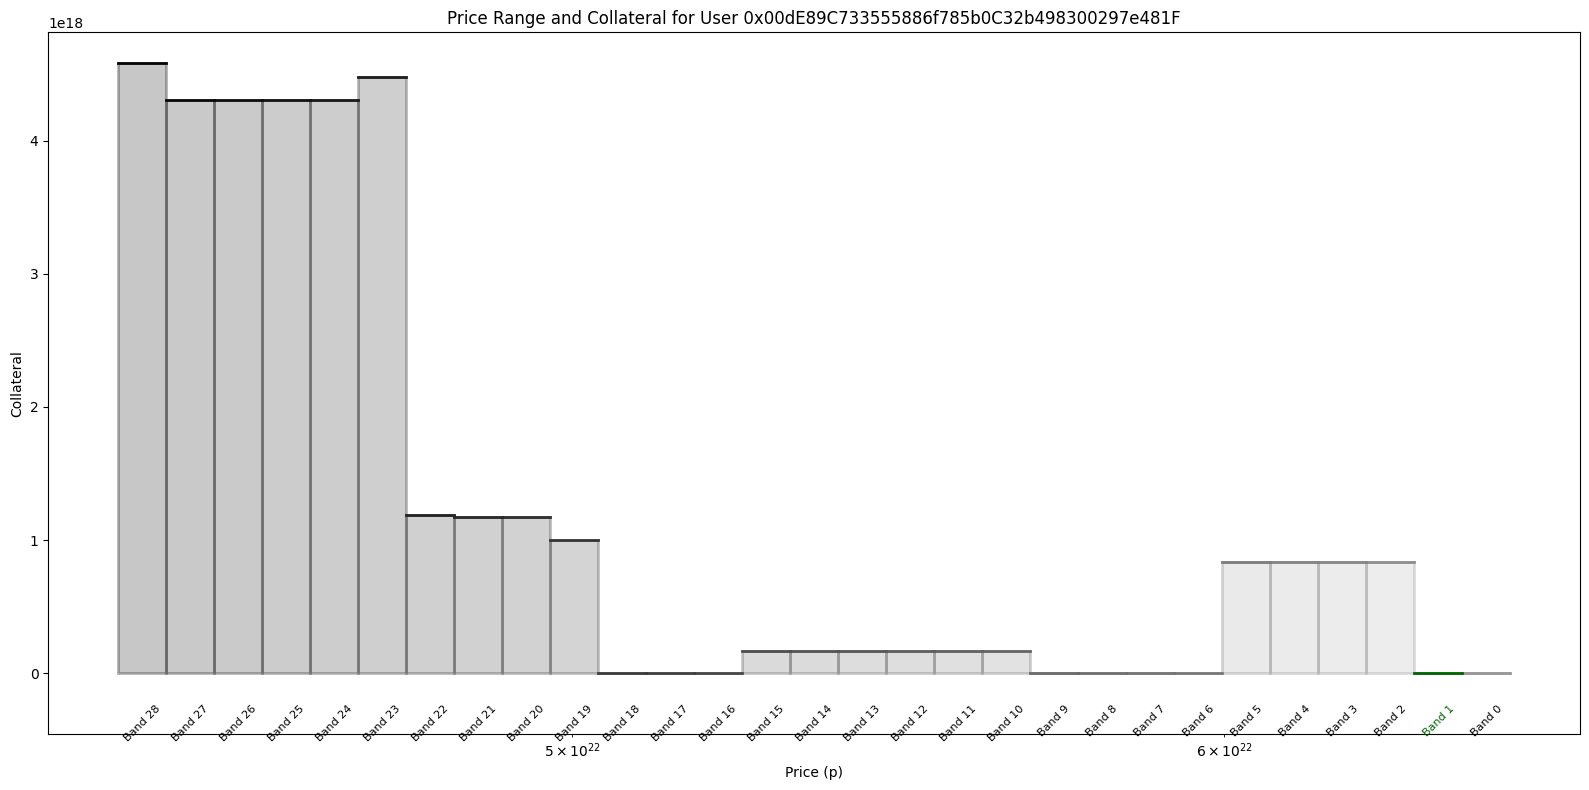

In [7]:
from helper import plot

# Approve tokens for trading
crvusd.approve(amm, 2**256 - 1)
wbtc.approve(amm, 2**256 - 1)

crvusd.approve(amm, 2**256 - 1, sender=alice)
wbtc.approve(amm, 2**256 - 1, sender=alice)

# Sanity check
print(f"Number of loans in the `{controller._name}` vault: {controller.n_loans()}")
plot(amm, user)

# Simulate Trade Using an Anchor


In [8]:
def get_wbtc_price():
    wbtc_price = amm.price_oracle()
    print(f"WBTC Price: {wbtc_price / 10 ** 18:,.4f}")    

def trade_crvusd_wbtc():
    print("Trading $crvUSD for $WBTC  ===============================")
    # Status pre-trade
    x_val = 100_000 * 10**18
    y_val = amm.get_dy(0, 1, x_val)

    print(f"The AMM will trade {x_val / 10 ** 18:,.4f} $crvUSD for {y_val / 10 ** 8:,.4f} $WBTC tokens")

    # Initial balances
    print("Starting Balance")
    user_balances(user, crvusd, wbtc, 8, "User")
    user_balances(alice, crvusd, wbtc, 8, "Alice")
    user_balances(amm_addr, crvusd, wbtc, 8, "AMM")

    amm.exchange(0, 1, x_val, int(y_val * .99), sender=alice)

    # Ending balances
    print("\nEnding Balance:")
    user_balances(user, crvusd, wbtc, 8, "User")
    user_balances(alice, crvusd, wbtc, 8, "Alice")
    user_balances(amm_addr, crvusd, wbtc, 8, "AMM")

    get_wbtc_price()

    # plot(amm, user)

def trade_wbtc_crvusd():
    print("Trading $WBTC for $crvUSD  ===============================")
    # Status pre-trade
    x_val = wbtc.balanceOf(alice)
    y_val = amm.get_dy(1, 0, x_val)
    print(f"The AMM will trade {x_val / 10 ** 8:,.4f} collateral tokens for {y_val / 10 ** 18:,.4f} $crvUSD")

    # Initial balances
    print("Starting Balance")
    user_balances(user, crvusd, wbtc, 8, "User")
    user_balances(alice, crvusd, wbtc, 8, "Alice")
    user_balances(amm_addr, crvusd, wbtc, 8, "AMM")

    amm.exchange(1, 0, x_val, int(y_val * .99), sender=alice)

    # Ending balances
    print("\nEnding Balance:")
    user_balances(user, crvusd, wbtc, 8, "User")
    user_balances(alice, crvusd, wbtc, 8, "Alice")
    user_balances(amm_addr, crvusd, wbtc, 8, "AMM")

    get_wbtc_price()

    # plot(amm, user)

# Test a trade
with boa.env.anchor():
    trade_crvusd_wbtc()
    trade_crvusd_wbtc()
    
    trade_wbtc_crvusd()

    

Trading $crvUSD for $WBTC  ===============================
The AMM will trade 100,000.0000 $crvUSD for 1.5068 $WBTC tokens
Starting Balance
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 500,000.0000
 - WBTC: 0.0000
AMM Balances:
 - crvUSD: 0.0000
 - WBTC: 82.0942

Ending Balance:
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 400,000.0000
 - WBTC: 1.5068
AMM Balances:
 - crvUSD: 100,000.0000
 - WBTC: 80.5874
WBTC Price: 63,640.6993
Trading $crvUSD for $WBTC  ===============================
The AMM will trade 100,000.0000 $crvUSD for 1.4211 $WBTC tokens
Starting Balance
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 400,000.0000
 - WBTC: 1.5068
AMM Balances:
 - crvUSD: 100,000.0000
 - WBTC: 80.5874

Ending Balance:
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 300,000.0000
 - WBTC: 2.9279
AMM Balances:
 - crvUSD: 200,000.0000
 - WBTC: 79.1663
WBTC

In [9]:
# do real trades
trade_crvusd_wbtc()
trade_crvusd_wbtc()

trade_wbtc_crvusd()

Trading $crvUSD for $WBTC  ===============================
The AMM will trade 100,000.0000 $crvUSD for 1.5068 $WBTC tokens
Starting Balance
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 500,000.0000
 - WBTC: 0.0000
AMM Balances:
 - crvUSD: 0.0000
 - WBTC: 82.0942

Ending Balance:
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 400,000.0000
 - WBTC: 1.5068
AMM Balances:
 - crvUSD: 100,000.0000
 - WBTC: 80.5874
WBTC Price: 63,640.6993
Trading $crvUSD for $WBTC  ===============================
The AMM will trade 100,000.0000 $crvUSD for 1.4211 $WBTC tokens
Starting Balance
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 400,000.0000
 - WBTC: 1.5068
AMM Balances:
 - crvUSD: 100,000.0000
 - WBTC: 80.5874

Ending Balance:
User Balances:
 - crvUSD: 439,871.0326
 - WBTC: 0.0000
Alice Balances:
 - crvUSD: 300,000.0000
 - WBTC: 2.9279
AMM Balances:
 - crvUSD: 200,000.0000
 - WBTC: 79.1663
WBTC

You Balances:
 - crvUSD: 0.0000
 - WBTC: 10.0000


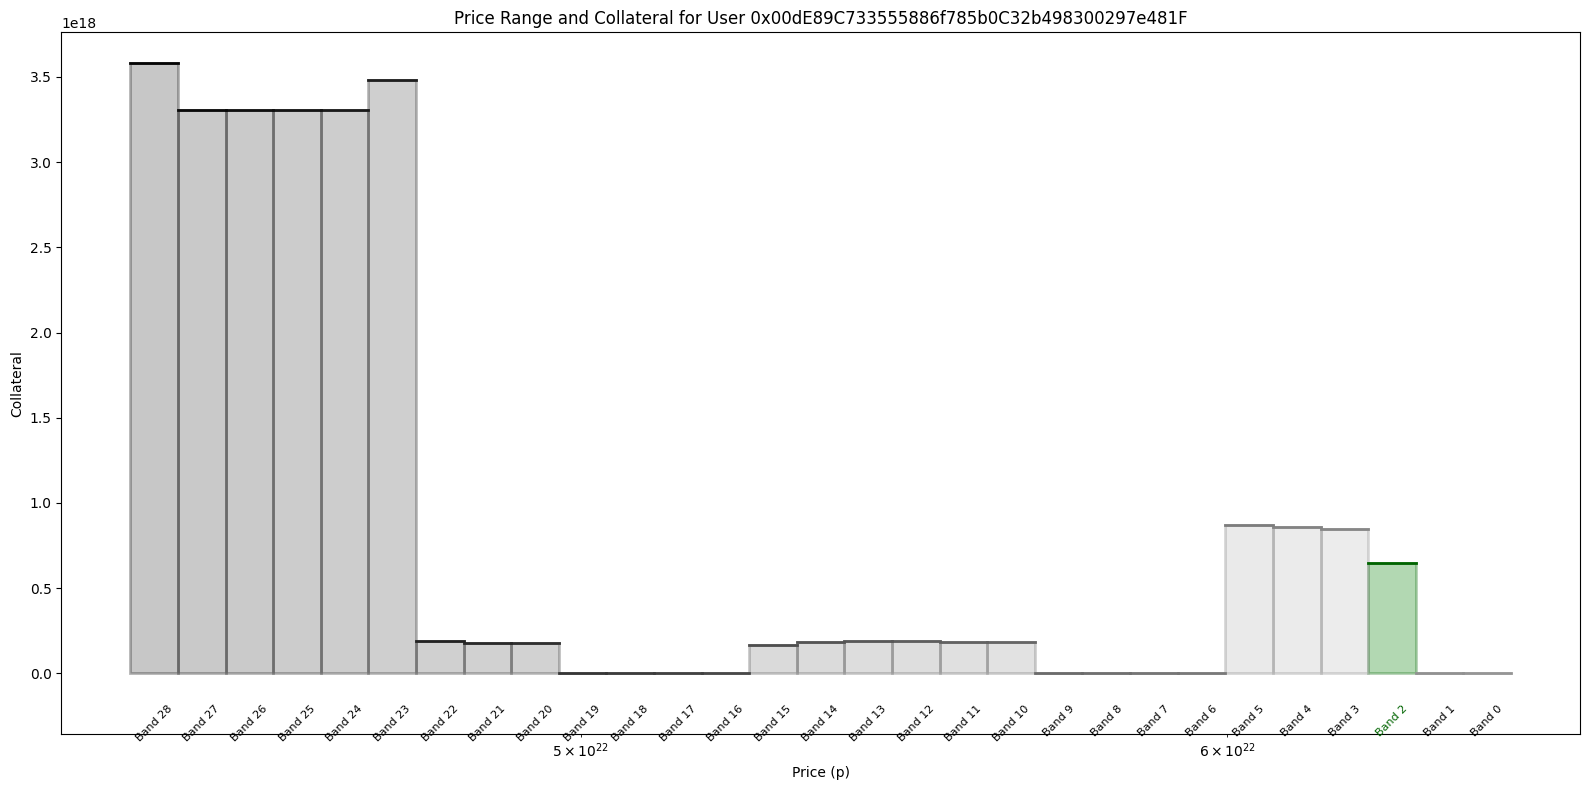

In [10]:
# Borrow
# Test a trade
crvusd.approve(controller, 2**256 - 1)

controller.repay(borrow_amount)
user_balances(user, crvusd, wbtc, 8, "User")
plot(amm, user)